# 第四章：训练模型

前几章讨论的几个模型都不知道具体的实施细节。

* 一：这一章，将从**线性回归模型**开始。介绍两种非常不同的训练模型的方法。  
    * 1、通过“闭式”方程——直接计算出最适合训练集的模型参数（也就是使训练集上的成本函数最小化的模型参数）  
    * 2、使用迭代优化的方法，即梯度下降（`GD`），逐渐调整模型参数直至训练集上的成本函数调至最低，最终趋同于第一种方法计算出来的模型参数。也会研究几个梯度下降的变体，包括批量梯度下降、小批量梯度下降以及随机梯度下降。  

* 二：进行多项式回归的讨论，这是一个更为复杂的模型，更适合非线性数据集。由于该模型的参数比线性模型更多，因此更容易造成对训练数据过度拟合，我们将使用学习曲线来分辨这种情况是否发生，然后再介绍几种正则化方法，降低过度拟合训练数据的风险。

* 三：学习两种经常用于分类任务的模型：`Logistic`回归和`Softmax`回归。

了解这些系统如何工作非常有帮助。针对你的任务，它有助于快速定位到合适的模型，正确的训练算法，以及一套适当的超参数。不仅如此，后期还能更高效的执行错误调试和错误分析。

## 准备工作

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images") # , CHAPTER_ID
os.makedirs(IMAGES_PATH, exist_ok=True)

# 存图片时，要先存（save_fig），再展示（show）
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 线性回归

在第1章中，学过一个简单的生活满意度的回归模型：life_satisfaction= $\theta_{0}+\theta_{1} \times \mathrm{GDP}_{-}$ per_capita

这个模型就是输入特征`GDP_per_capita`的线性函数，$\theta_{0}$和$\theta_{1}$是模型的参数。  
更为概括的说，线性模型就是对输入特征加权求和，再加上一个偏置项（也称为截距项）的常数。  
公式如下：  
<center>$\hat{y}=\theta_{0}+\theta_{1} x_{1}+\theta_{2} x_{2}+\cdots+\theta_{n} x_{n}$</center>

* $\hat{y}$是预测值  

* $n$是特征的数量  

* $x_{\mathrm{i}}$是第$i$个特征值

* $\theta_{j}$是第$j$个模型参数（包括偏执项$\theta_{0}$以及特征权重$\theta_{1}$,$\theta_{2}$,···,$\theta_{n}$）

这也可以用更为简单的向量化形式表达，公式如下：  
<center>$\hat{y}=h_{\theta}(\mathbf{x})=\theta^{T} \cdot \mathbf{x}$</center>

* $\theta$是模型的参数向量，包括偏置项$\theta_{0}$以及特征权重$\theta_{1}$到$\theta_{n}$

* $\theta^{T}$是$\theta$的转置向量

* $\mathbf{X}$是实例的特征向量，包括从$x_{0}$到$x_{n}$，$x_{0}$永远为1

* $\theta^{T} \cdot \mathbf{x}$是$\theta^{T}$和$\mathbf{X}$的点积

* $h_{\theta}$是使用模型参数$\theta$的假设函数

训练模型就是设置模型参数直到模型最适应训练集的过程。要达到这个目的，首先需要知道怎么衡量模型对训练数据的拟合程度是好还是差。在第2章中，我们了解到回归模型最常见的性能指标是均方根误差（`RMSE`）。因此，在训练线性回归模型时，需要找到最小化`RMSE`的$\theta$值，在实践中，将均方误差（`MSE`）最小化比最小化`RMSE`更为简单，二者效果相同（因为使函数最小化的值，同样也使其平方根最小。）<sup>注1</sup>

在训练集$\mathbf{X}$上，使用如下公式计算线性回归的`MSE`，$h_{\theta}$为假设函数  
<center>$\operatorname{MSE}\left(\mathbf{X}, h_{\theta}\right)=\frac{1}{m} \sum_{i=1}^{m}\left(\theta^{T} \cdot \mathbf{x}^{(i)}-y^{(i)}\right)^{2}$</center>

注1：通常情况下，学习算法优化的函数都与评估最终模型时使用的性能指标函数不同。这可能是1、前者更容易计算；2、前者具有某些后者缺乏的差异属性；3、想在训练期间约束模型。

### 标准方程

提供一个闭式解方法（直接得出结果的数学方程--标准方程）**标准方程只能用于线性回归**

<center>$\widehat{\theta}=\left(X^{T} \cdot X\right)^{-1} \cdot X^{T} \cdot \mathrm{y}$</center>

* $\widehat{\theta}$是使成本函数最小的${\theta}$值
* $y$是包含$y^{(1)}$到$y^{(m)}$的目标值向量

In [2]:
# 生成一些线性数据来测试这个公式
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# 接下来计算theta_hat，使用np.linalg中的inv()函数来对矩阵求逆，并用dot()方法计算矩阵的内积
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

用来生成数据的函数是$y=4+3x_{0}+高斯噪声$，期望得到的${\theta_{0}}=4$，${\theta_{1}}=3$，实际得到的结果是${\theta_{0}}=3.815$，${\theta_{1}}=3.184$。这两个结果非常接近（因为存在高斯噪声的缘故不可能完全一样）。

下面用$\widehat{\theta}$做预测

In [3]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

Saving figure 预测随机生成的线性数据


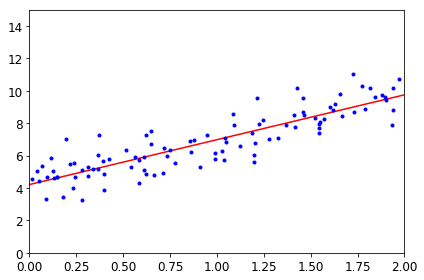

In [4]:
# 绘制模型的预测情况
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
save_fig("预测随机生成的线性数据")
plt.show()

In [5]:
# Scikit-Learn 的等效代码：
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [6]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

### 计算复杂度

标准方程的计算复杂度通常为$O(n^{2.4})$到$O(n^{3})$之间。所以，当特征向量翻倍时，计算时间大约在$2^{2.4}=5.3$到$2^{3}=8$倍之间。

好的一方面是，对于训练集中的实例数量来说，方程是线性的，所以能够有效地处理大量的训练集（只要内存足够）。

接下来，看几个适合特征数或者训练实例数量大到内存无法满足要求时的模型训练方法。

## 梯度下降

梯度下降能够为大范围的问题找到最优解：通过测量参数向量${\theta}$相关的误差函数的局部梯度，并不断沿着降低梯度的方向调整，直到梯度降为0，到达最小值。

具体来说，首先使用一个随机的${\theta}$值（随机初始化），然后逐步改进，每次踏出一步，每一步都尝试降低一点成本函数，知道算法收敛出一个最小值。
<img src="./images/Book/梯度下降.jpg" width="50%" height="50%"></img>

**存在的问题：**
* 当学习率太低时，算法需要经过大量迭代才能收敛，将耗费很长时间
<img src="./images/Book/学习率太低.jpg" width="50%" height="50%"></img>
* 如果学习率太高，会导致算法发散，值越来越大。
<img src="./images/Book/学习率太高.jpg" width="50%" height="50%"></img>
* 并不是所有的成本函数都像一个漂亮的碗，不同形状的成本函数会收敛到一个局部最小值而不是全局最小值。
<img src="./images/Book/梯度下降陷阱.jpg" width="50%" height="50%"></img>

    幸好，线性回归模型的成本函数恰好是一个凸函数，也就是说不存在局部最小，只有一个全局最小值。同时他也是一个连续函数，所以斜率不会产生陡峭的变化。**结论**：即便是乱走，梯度下降都可以趋近到全局最小值。
* 成本函数虽然是碗状的，但如果不同特征的尺寸差别巨大，那它可能是一个非常细小的碗，这将导致收敛缓慢。**所以要保证所有特征值的大小比例都差不多**
<img src="./images/Book/特征值缩放和特征值无缩放的梯度下降.jpg" width="50%" height="50%"></img>
* 模型的参数越多，这个空间的维度就越多，搜索就越难。

### 批量梯度下降

要实现梯度下降，需要计算每个模型关于参数$\theta_{j}$的成本函数的梯度。

* 成本函数的偏导数计算公式：

<center>$\frac{\partial}{\partial \theta_{j}} \operatorname{MSE}(\theta)=\frac{2}{m} \sum_{i=1}^{m}\left(\theta^{T} \cdot \mathbf{x}^{(i)}-y^{(i)}\right) x_{j}^{(i)}$</center>

* 成本函数的梯度向量：

<center>$\nabla_{\theta} \operatorname{MSE}(\theta)=\left(\begin{array}{c}\frac{\partial}{\partial \theta_{0}} \operatorname{MSE}(\theta) \\ \frac{\partial}{\partial \theta_{1}} \operatorname{MSE}(\theta) \\ \vdots \\ \frac{\partial}{\partial \theta_{n}} \operatorname{MSE}(\theta)\end{array}\right)=\frac{2}{m} \mathbf{X}^{T} \cdot(\mathbf{X} \cdot \theta-\mathbf{y})$</center>

**注意**，批量梯度下降在计算梯度下降的每一步时，都是基于完整的训练集，因此，面对非常庞大的训练集时，算法会变得极慢。但是，相较于标准方程，梯度下降算法随特征向量扩展的表现更好。

一旦有了梯度向量，哪个点向上，就朝反方向下坡，也就是从$\theta$中减去$\nabla_{\theta} \operatorname{MSE}(\theta)$。这时用梯度向量乘以$\eta$确定下坡步长的大小。

* 梯度下降步长：
<center>$\theta^{(\text {next step })}=\theta-\eta \nabla_{\theta} \operatorname{MSE}(\theta)$</center>

In [7]:
# 看看这个算法的快速实现
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
theta

array([[4.21509616],
       [2.77011339]])

尝试不同的学习率：
<img src="./images/Book/不同学习率的梯度下降.jpg" width="70%" height="70%"></img>

从图中看出，左图的学习率太低，算法最终可以找到解决方法，但是要较长时间。中间的学习率正好。而右边的学习率太高导致算法发散，找不到解决方法。

要找到合适的学习率，可以使用网格搜索，但是需要限制迭代次数，这样网格搜索可以淘汰掉那些收敛耗时太长的模型。一个简单方法是：开始设置一个非常大的迭代次数，当梯度向量的值变得很微小时中断算法---也就是当它的范数变得低于$\mathcal{E}$（容差）时，这时梯度下降（几乎）已经到达了最小值。

<center>收敛率</center>
成本函数为凸函数，且斜率没有陡峭变化时（如MSE成本函数），通过批量梯度下降可以看出一个固定的学习率有一个收敛率，为$O\left(\frac{1}{\text { iterations }}\right)$。所以，如果将容差$\mathcal{E}$缩小为原来的1/10（以获得更精确的解），算法将运行10倍的迭代次数。

### 随机梯度下降

批量梯度下降的主要问题是它要用整个训练集来计算每一步的梯度，所以当训练集很大时，算法会特别慢。而随机梯度下降是与之相反，每一步都是在训练集中随机选取一个实例来计算梯度，这样明显就会快很多。

另一方面，随机梯度下降比批量梯度下降要不规则的多，成本函数不再是缓缓降低直到抵达最小值，而是不断上上下下，但从整体来看，还是慢慢下降，**但是即使它达到了最小值，依旧还会持续反弹，永远不会停止。所以算法停下来的参数值肯定是足够好的，但不是最优的。**
<img src="./images/Book/随机梯度下降.jpg" width="50%" height="50%"></img>
当成本函数不规则时，随机梯度下降其实可以帮助算法跳出局部最小值，所以当成本函数不规则时，随机梯度下降更容易找到全局最小值。

随机性的**好处**在于可以逃离局部最优，但缺点是永远定位不出最小值。要解决这个困境，有一个办法是逐步降低学习率。开始的步长比较大（这有助于快速进展和逃离局部最小值），然后越来越小，让算法尽量靠近全局最小值。这个过程叫做**模拟退火**，确定每个迭代学习率的函数叫做学习计划。如果学习率降的太快，可能会陷入局部最小值。如果学习率降的太慢，需要太长时间才能跳到差不多最小值附近。

In [8]:
# 使用一个简单的学习计划实现随机梯度下降：
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

theta

array([[4.18475289],
       [2.73036719]])

前面的批量梯度下降需要在整个训练集上迭代1000次，而这段代码只迭代了50次就得到了一个相当不错的解。

<img src="./images/Book/随机梯度下降的前10步.jpg" width="50%" height="50%"></img>

训练过程的前10步显示了随机梯度的不规则性。

In [9]:
# 在SKLearn中，用SGD执行线性回归可以使用SGDRegressor类，其默认优化的成本函数是平方误差。
# 下面这段代码从学习率0.1开始（eta0=0.1）使用默认的学习计划运行了50轮。
# 用SKLearn得到的结果和标准方程的解非常相近。
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter_no_change=50, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([4.18552107]), array([2.72964007]))

### 小批量梯度下降

小批量梯度下降的每一步梯度计算，既不是基于整个训练集，也不是基于单个实例，而是基于一小部分随机的实例集。小批量梯度下降的主要优势在于可以从矩阵运算的硬件优化中获得显著的性能提升，特别是需要用到图形处理器时。

一方面，小批量梯度下降在参数空间层面的前进过程不想SGD那样不稳定，特别是批量较大时，所以小批量梯度下降最终会比SGD更接近最小值一些。但是另一方面，**它可能更难从局部最小值中逃脱**。

<img src="./images/Book/梯度下降的参数路径.jpg" width="50%" height="50%"></img>

从图中看三种梯度下降算法的前进路线，批量梯度下降最终停在了最小值上，而随机梯度下降和小批量梯度下降还在继续游走。但是批量梯度下降是花费了大量时间计算出来的。如果用好了学习计划，随机梯度下降和小批量梯度下降也同样能到达最小值。

最后，**比较一下**到目前为止所讨论过的线性回归模型（m是训练实例的数量，n是特征数量）

**注：**
* 标准方程只能用于线性回归，但是梯度下降还可以用于训练许多其他模型。
* 训练后的模型几乎无差别，所以这些算法最后出来的模型都非常相似，并且以完全相同的方式做出预测。
    
|  算法   | m很大  | 是否支持核外 | n很大 | 超参数 | 是否需要缩放 | Scikit-Learn |
|  :----:  | :----:  | :----: | :----: | :----: | :----: | :----: |
| 标准方程  | 快 | 否 | 慢 | 0 | 否 | LinearRegression |
| 批量梯度下降  | 慢 | 否 | 快 | 2 | 是 | n/a |
| 随机梯度下降  | 快 | 是 | 快 | ${\geq}$2 | 是 | SGDRegressor |
| 小批量梯度下降  | 快 | 是 | 快 | ${\geq}$2 | 是 | n/a |

## 多项式回归

当数据比简单的直线更为复杂时，一个简单的方法是：将每个特征的幂次方添加为一个新特征，然后在这个扩展过的特征集上训练线性模型。这就称之为多项式回归。

Saving figure 生成的非线性带噪声数据集


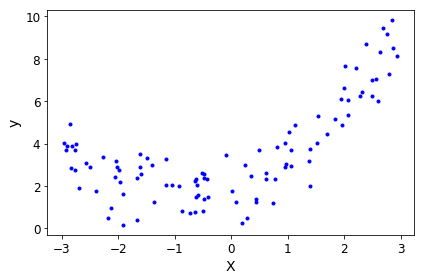

In [29]:
# 举一个只有一个特征的例子
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
plt.plot(X, y, "b.")
plt.xlabel("X")
plt.ylabel("y")
save_fig("生成的非线性带噪声数据集")
plt.show()

显然，直线永远不可能拟合这个数据。所以我们使用Scikit-Learn的PolynomialFeatures类来对训练数据进行转换，将每个特征的平方作为新特征加入训练集。

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.8706139]), array([-0.8706139 ,  0.75796856]))

In [31]:
# X_poly现在包含原本的特征X和该特征的平方，现在对这个扩展后的训练集匹配一个LinearRegression模型
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.96951293]), array([[0.87151168, 0.5082167 ]]))

Saving figure 多项式回归模型预测


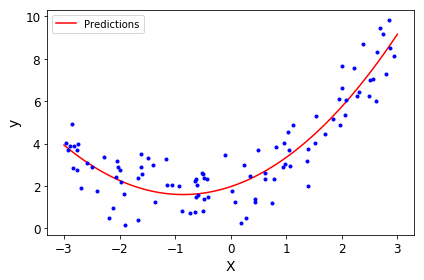

In [53]:
# 画出拟合曲线（重新生成100个数据用于预测，并拟合。）
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_predict = lin_reg.predict(X_new_poly)
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
save_fig("多项式回归模型预测")
plt.show()

**注意，当存在多个特征时，多项式回归能够发现特征和特征之间的关系。**因为PolynomialFeatures会在给定的多项式阶数下，添加所有特征组合。PolynomialFeatures(degreee=d)可以将一个包含n个特征的数组转换为包含$\frac{(n+d) !}{d ! n !}$个特征的数组。**要小心特征组合的数量爆炸**